In [18]:
import pandas as pd
import numpy as np
import lightgbm as ltb
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import dask.dataframe as dd
import time 

pd.set_option('display.max_columns', 500)

In [5]:
t1 = time.time()

INPUT = '../../01_Preparation/Data/featured_train.h5'
OUTPUT_FEATS = 'features.npy'
OUTPUT = '../Data/prepared_train.h5'

# Read merged data for sampling
data = pd.read_hdf(INPUT, key='featured_train')

In [19]:
data.head(5)


,CUSTOMER_ID,OK_13M,OK_15M,BRANDFAMILY_ID,Midcategory,R_0,CAL_DATE_0,CAL_DATE_end_0,SI_ITG_WSE_0,SI_MRKT_WSE_0,SO_ITG_WSE_0,SO_MRKT_WSE_0,MECHERO_0,CLIPPER_0,ABP_0,ABP_ESP_0,DISPENSADOR_0,DISPENSADOR_ESP_0,VISIBILIDAD_0,VISIBILIDAD_ESP_0,AZAFATA_0,TOTEM_0,TOTEM_ESP_0,SVM_0,TFT_0,CUE_0,VISIT_0,R_1,CAL_DATE_1,CAL_DATE_end_1,SI_ITG_WSE_1,SI_MRKT_WSE_1,SO_ITG_WSE_1,SO_MRKT_WSE_1,MECHERO_1,CLIPPER_1,ABP_1,ABP_ESP_1,DISPENSADOR_1,DISPENSADOR_ESP_1,VISIBILIDAD_1,VISIBILIDAD_ESP_1,AZAFATA_1,TOTEM_1,TOTEM_ESP_1,SVM_1,TFT_1,CUE_1,VISIT_1,R_2,CAL_DATE_2,CAL_DATE_end_2,SI_ITG_WSE_2,SI_MRKT_WSE_2,SO_ITG_WSE_2,SO_MRKT_WSE_2,MECHERO_2,CLIPPER_2,ABP_2,ABP_ESP_2,DISPENSADOR_2,DISPENSADOR_ESP_2,VISIBILIDAD_2,VISIBILIDAD_ESP_2,AZAFATA_2,TOTEM_2,TOTEM_ESP_2,SVM_2,TFT_2,CUE_2,VISIT_2,R_3,CAL_DATE_3,CAL_DATE_end_3,SI_ITG_WSE_3,SI_MRKT_WSE_3,SO_ITG_WSE_3,SO_MRKT_WSE_3,MECHERO_3,CLIPPER_3,ABP_3,ABP_ESP_3,DISPENSADOR_3,DISPENSADOR_ESP_3,VISIBILIDAD_3,VISIBILIDAD_ESP_3,AZAFATA_3,TOTEM_3,TOTEM_ESP_3,SVM_3,TFT_3,CUE_3,VISIT_3,R_4,CAL_DATE_4,CAL_DATE_end_4,SI_ITG_WSE_4,SI_MRKT_WSE_4,SO_ITG_WSE_4,SO_MRKT_WSE_4,MECHERO_4,CLIPPER_4,ABP_4,ABP_ESP_4,DISPENSADOR_4,DISPENSADOR_ESP_4,VISIBILIDAD_4,VISIBILIDAD_ESP_4,AZAFATA_4,TOTEM_4,TOTEM_ESP_4,SVM_4,TFT_4,CUE_4,VISIT_4,R_5,CAL_DATE_5,CAL_DATE_end_5,SI_ITG_WSE_5,SI_MRKT_WSE_5,SO_ITG_WSE_5,SO_MRKT_WSE_5,MECHERO_5,CLIPPER_5,ABP_5,ABP_ESP_5,DISPENSADOR_5,DISPENSADOR_ESP_5,VISIBILIDAD_5,VISIBILIDAD_ESP_5,AZAFATA_5,TOTEM_5,TOTEM_ESP_5,SVM_5,TFT_5,CUE_5,VISIT_5,customer_id,label,QUOTA_SELLIN_0,QUOTA_SELLOUT_0,QUOTA_SELLIN_1,QUOTA_SELLOUT_1,QUOTA_SELLIN_2,QUOTA_SELLOUT_2,QUOTA_SELLIN_3,QUOTA_SELLOUT_3,QUOTA_SELLIN_4,QUOTA_SELLOUT_4,QUOTA_SELLIN_5,QUOTA_SELLOUT_5,sellin_itg_mean,sellin_itg_var,sellin_itg_std,sellin_itg_sum,sellin_mrkt_mean,sellin_mrkt_var,sellin_mrkt_std,sellin_mrkt_sum,qouta_sellin_mean,qouta_sellin_var,qouta_sellin_std,qouta_sellin_sum,MECHERO_mean,MECHERO_var,MECHERO_std,MECHERO_sum,CLIPPER_mean,CLIPPER_var,CLIPPER_std,CLIPPER_sum,ABP_mean,ABP_var,ABP_std,ABP_sum,DISPENSADOR_mean,DISPENSADOR_var,DISPENSADOR_std,DISPENSADOR_sum,VISIBILIDAD_mean,VISIBILIDAD_var,VISIBILIDAD_std,VISIBILIDAD_sum,VISIBILIDAD_ESP_mean,VISIBILIDAD_ESP_var,VISIBILIDAD_ESP_std,VISIBILIDAD_ESP_sum,AZAFATA_mean,AZAFATA_var,AZAFATA_std,AZAFATA_sum,TOTEM_mean,TOTEM_var,TOTEM_std,TOTEM_sum,TOTEM_ESP_mean,TOTEM_ESP_var,TOTEM_ESP_std,TOTEM_ESP_sum,SVM_mean,SVM_var,SVM_std,SVM_sum,TFT_mean,TFT_var,TFT_std,TFT_sum,CUE_mean,CUE_var,CUE_std,CUE_sum,VISIT_mean,VISIT_var,VISIT_std,VISIT_sum,SEASON,SEASON_WINTER,SEASON_SPRING,SEASON_SUMMER,SEASON_AUTUMN
0,46010526,1,1,BF234104,Blond,8,2017-12-21,2017-12-31,5176.0,2674944.0,3819.0,31284.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,2018-01-01,2018-01-10,5172.0,3514468.0,4080.0,25234.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,2018-01-11,2018-01-21,5666.0,4210040.0,3034.0,30147.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,2018-01-22,2018-01-31,4408.0,3674853.0,3572.0,23231.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,12,2018-02-01,2018-02-08,3632.0,2736840.0,2732.0,19146.0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,2018-02-09,2018-02-19,5180.0,3254706.0,4311.0,26587.0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46010526.0,0.0,0.193499,12.207518,0.147163,16.168661,0.134583,10.064020,0.119950,15.376006,0.132708,14.269299,0.159154,16.214691,4810.8,636755.2,797.969423,24054.0,3362229.0,4.257915e+11,6.525270e+05,16811145.0,0.145581,0.000811,0.028470,0.727904,1.0,5.0,2.236068,5,0.0,0.0,0.00000,0,0.0,0.0,0.000000,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.2,0.2,0.447214,1,0,1,0,0,0
1,12000436,1,1,BF241151,Ryo,16,2018-10-01,2018-10-09,229.0,145428.0,80.0,1816.0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,17,2018-10-10,2018-10-21,572.0,274800.0,520.0,3078.0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,18,2018-10-22,2018-10-31,850.0,571610.0,360.0,5902.0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,19,2018-11-01,2018-11-12,867.0,555289.0,200.0,3146.0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,20,2018-11-13,2018-11-21,915.0,436128.0,440.0,28

In [7]:
date_cols = []
for field in data.columns.values:
    element = field.lower()
    if 'date' in element:
        date_cols.append(field)

In [8]:
date_cols


['CAL_DATE_0',
 'CAL_DATE_end_0',
 'CAL_DATE_1',
 'CAL_DATE_end_1',
 'CAL_DATE_2',
 'CAL_DATE_end_2',
 'CAL_DATE_3',
 'CAL_DATE_end_3',
 'CAL_DATE_4',
 'CAL_DATE_end_4',
 'CAL_DATE_5',
 'CAL_DATE_end_5']

In [16]:
cols = []
for field in data.columns.values:
        element = field.lower()
        if ('so_' in element) or ('si' in element and '5' in element) \
        or ('sellout' in element and '_5' not in element) or ('sellin' in element and '5' in element) \
        or 'fecha' in element or 'date' in element:
            cols.append(field)
cols     

['CAL_DATE_0',
 'CAL_DATE_end_0',
 'SO_ITG_WSE_0',
 'SO_MRKT_WSE_0',
 'CAL_DATE_1',
 'CAL_DATE_end_1',
 'SO_ITG_WSE_1',
 'SO_MRKT_WSE_1',
 'CAL_DATE_2',
 'CAL_DATE_end_2',
 'SO_ITG_WSE_2',
 'SO_MRKT_WSE_2',
 'CAL_DATE_3',
 'CAL_DATE_end_3',
 'SO_ITG_WSE_3',
 'SO_MRKT_WSE_3',
 'CAL_DATE_4',
 'CAL_DATE_end_4',
 'SO_ITG_WSE_4',
 'SO_MRKT_WSE_4',
 'CAL_DATE_5',
 'CAL_DATE_end_5',
 'SI_ITG_WSE_5',
 'SI_MRKT_WSE_5',
 'SO_ITG_WSE_5',
 'SO_MRKT_WSE_5',
 'VISIBILIDAD_5',
 'VISIBILIDAD_ESP_5',
 'VISIT_5',
 'QUOTA_SELLOUT_0',
 'QUOTA_SELLOUT_1',
 'QUOTA_SELLOUT_2',
 'QUOTA_SELLOUT_3',
 'QUOTA_SELLOUT_4',
 'QUOTA_SELLIN_5']

In [22]:
to_delete = cols+['Midcategory', 'R_0', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5']
    
X = data.drop(to_delete, axis=1)
X = X.drop(['BRANDFAMILY_ID', 'label', 'customer_id', 'CUSTOMER_ID', 'QUOTA_SELLOUT_5', 'OK_13M', 'OK_15M'], axis=1)
y = data['QUOTA_SELLOUT_5']


In [23]:
X.head()

,SI_ITG_WSE_0,SI_MRKT_WSE_0,MECHERO_0,CLIPPER_0,ABP_0,ABP_ESP_0,DISPENSADOR_0,DISPENSADOR_ESP_0,VISIBILIDAD_0,VISIBILIDAD_ESP_0,AZAFATA_0,TOTEM_0,TOTEM_ESP_0,SVM_0,TFT_0,CUE_0,VISIT_0,SI_ITG_WSE_1,SI_MRKT_WSE_1,MECHERO_1,CLIPPER_1,ABP_1,ABP_ESP_1,DISPENSADOR_1,DISPENSADOR_ESP_1,VISIBILIDAD_1,VISIBILIDAD_ESP_1,AZAFATA_1,TOTEM_1,TOTEM_ESP_1,SVM_1,TFT_1,CUE_1,VISIT_1,SI_ITG_WSE_2,SI_MRKT_WSE_2,MECHERO_2,CLIPPER_2,ABP_2,ABP_ESP_2,DISPENSADOR_2,DISPENSADOR_ESP_2,VISIBILIDAD_2,VISIBILIDAD_ESP_2,AZAFATA_2,TOTEM_2,TOTEM_ESP_2,SVM_2,TFT_2,CUE_2,VISIT_2,SI_ITG_WSE_3,SI_MRKT_WSE_3,MECHERO_3,CLIPPER_3,ABP_3,ABP_ESP_3,DISPENSADOR_3,DISPENSADOR_ESP_3,VISIBILIDAD_3,VISIBILIDAD_ESP_3,AZAFATA_3,TOTEM_3,TOTEM_ESP_3,SVM_3,TFT_3,CUE_3,VISIT_3,SI_ITG_WSE_4,SI_MRKT_WSE_4,MECHERO_4,CLIPPER_4,ABP_4,ABP_ESP_4,DISPENSADOR_4,DISPENSADOR_ESP_4,VISIBILIDAD_4,VISIBILIDAD_ESP_4,AZAFATA_4,TOTEM_4,TOTEM_ESP_4,SVM_4,TFT_4,CUE_4,VISIT_4,MECHERO_5,CLIPPER_5,ABP_5,ABP_ESP_5,DISPENSADOR_5,DISPENSADOR_ESP_5,AZAFATA_5,TOTEM_5,TOTEM_ESP_5,SVM_5,TFT_5,CUE_5,QUOTA_SELLIN_0,QUOTA_SELLIN_1,QUOTA_SELLIN_2,QUOTA_SELLIN_3,QUOTA_SELLIN_4,sellin_itg_mean,sellin_itg_var,sellin_itg_std,sellin_itg_sum,sellin_mrkt_mean,sellin_mrkt_var,sellin_mrkt_std,sellin_mrkt_sum,qouta_sellin_mean,qouta_sellin_var,qouta_sellin_std,qouta_sellin_sum,MECHERO_mean,MECHERO_var,MECHERO_std,MECHERO_sum,CLIPPER_mean,CLIPPER_var,CLIPPER_std,CLIPPER_sum,ABP_mean,ABP_var,ABP_std,ABP_sum,DISPENSADOR_mean,DISPENSADOR_var,DISPENSADOR_std,DISPENSADOR_sum,VISIBILIDAD_mean,VISIBILIDAD_var,VISIBILIDAD_std,VISIBILIDAD_sum,VISIBILIDAD_ESP_mean,VISIBILIDAD_ESP_var,VISIBILIDAD_ESP_std,VISIBILIDAD_ESP_sum,AZAFATA_mean,AZAFATA_var,AZAFATA_std,AZAFATA_sum,TOTEM_mean,TOTEM_var,TOTEM_std,TOTEM_sum,TOTEM_ESP_mean,TOTEM_ESP_var,TOTEM_ESP_std,TOTEM_ESP_sum,SVM_mean,SVM_var,SVM_std,SVM_sum,TFT_mean,TFT_var,TFT_std,TFT_sum,CUE_mean,CUE_var,CUE_std,CUE_sum,VISIT_mean,VISIT_var,VISIT_std,VISIT_sum,SEASON,SEASON_WINTER,SEASON_SPRING,SEASON_SUMMER,SEASON_AUTUMN
0,5176.0,2674944.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5172.0,3514468.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5666.0,4210040.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4408.0,3674853.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3632.0,2736840.0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0.193499,0.147163,0.134583,0.119950,0.132708,4810.8,636755.2,797.969423,24054.0,3362229.0,4.257915e+11,6.525270e+05,16811145.0,0.145581,0.000811,0.028470,0.727904,1.0,5.0,2.236068,5,0.0,0.0,0.00000,0,0.0,0.0,0.000000,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.2,0.2,0.447214,1,0,1,0,0,0
1,229.0,145428.0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,572.0,274800.0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,850.0,571610.0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,867.0,555289.0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,915.0,436128.0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0.157466,0.208151,0.148703,0.156135,0.209801,686.6,83485.3,288.938229,3433.0,396651.0,3.382394e+10,1.839129e+05,1983255.0,0.176051,0.000915,0.030247,0.880256,0.0,0.0,0.000000,0,4.4,6.3,2.50998,22,0.0,0.0,0.000000,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.6,1.8,1.341641,3,3,0,0,0,1
2,9956.0,7663012.0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,11855.0,7912300.0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,8,8715.0,7341030.0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,3,15880.0,16918200.0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,13792.0,11640300.0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0.129923,0.149830,0.118716,0.093863,0.118485,12039.6,8312002.3,2883.054335,60198.0,10294968.4,1.675179e+13,4.092895e+06,51474842.0,0.122163,0.000413,0.020322,0.610817,0.0,0.0,0.000000,0,0.0,0.0,0.00000,0,6.8,9.7,3.114482,34,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,2.2,12.2,3.492850,11,2,0,0,1,0
3,1086.0,3115019.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,915.0,4432320.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,800.0,6

In [54]:
correlations = X.corr()

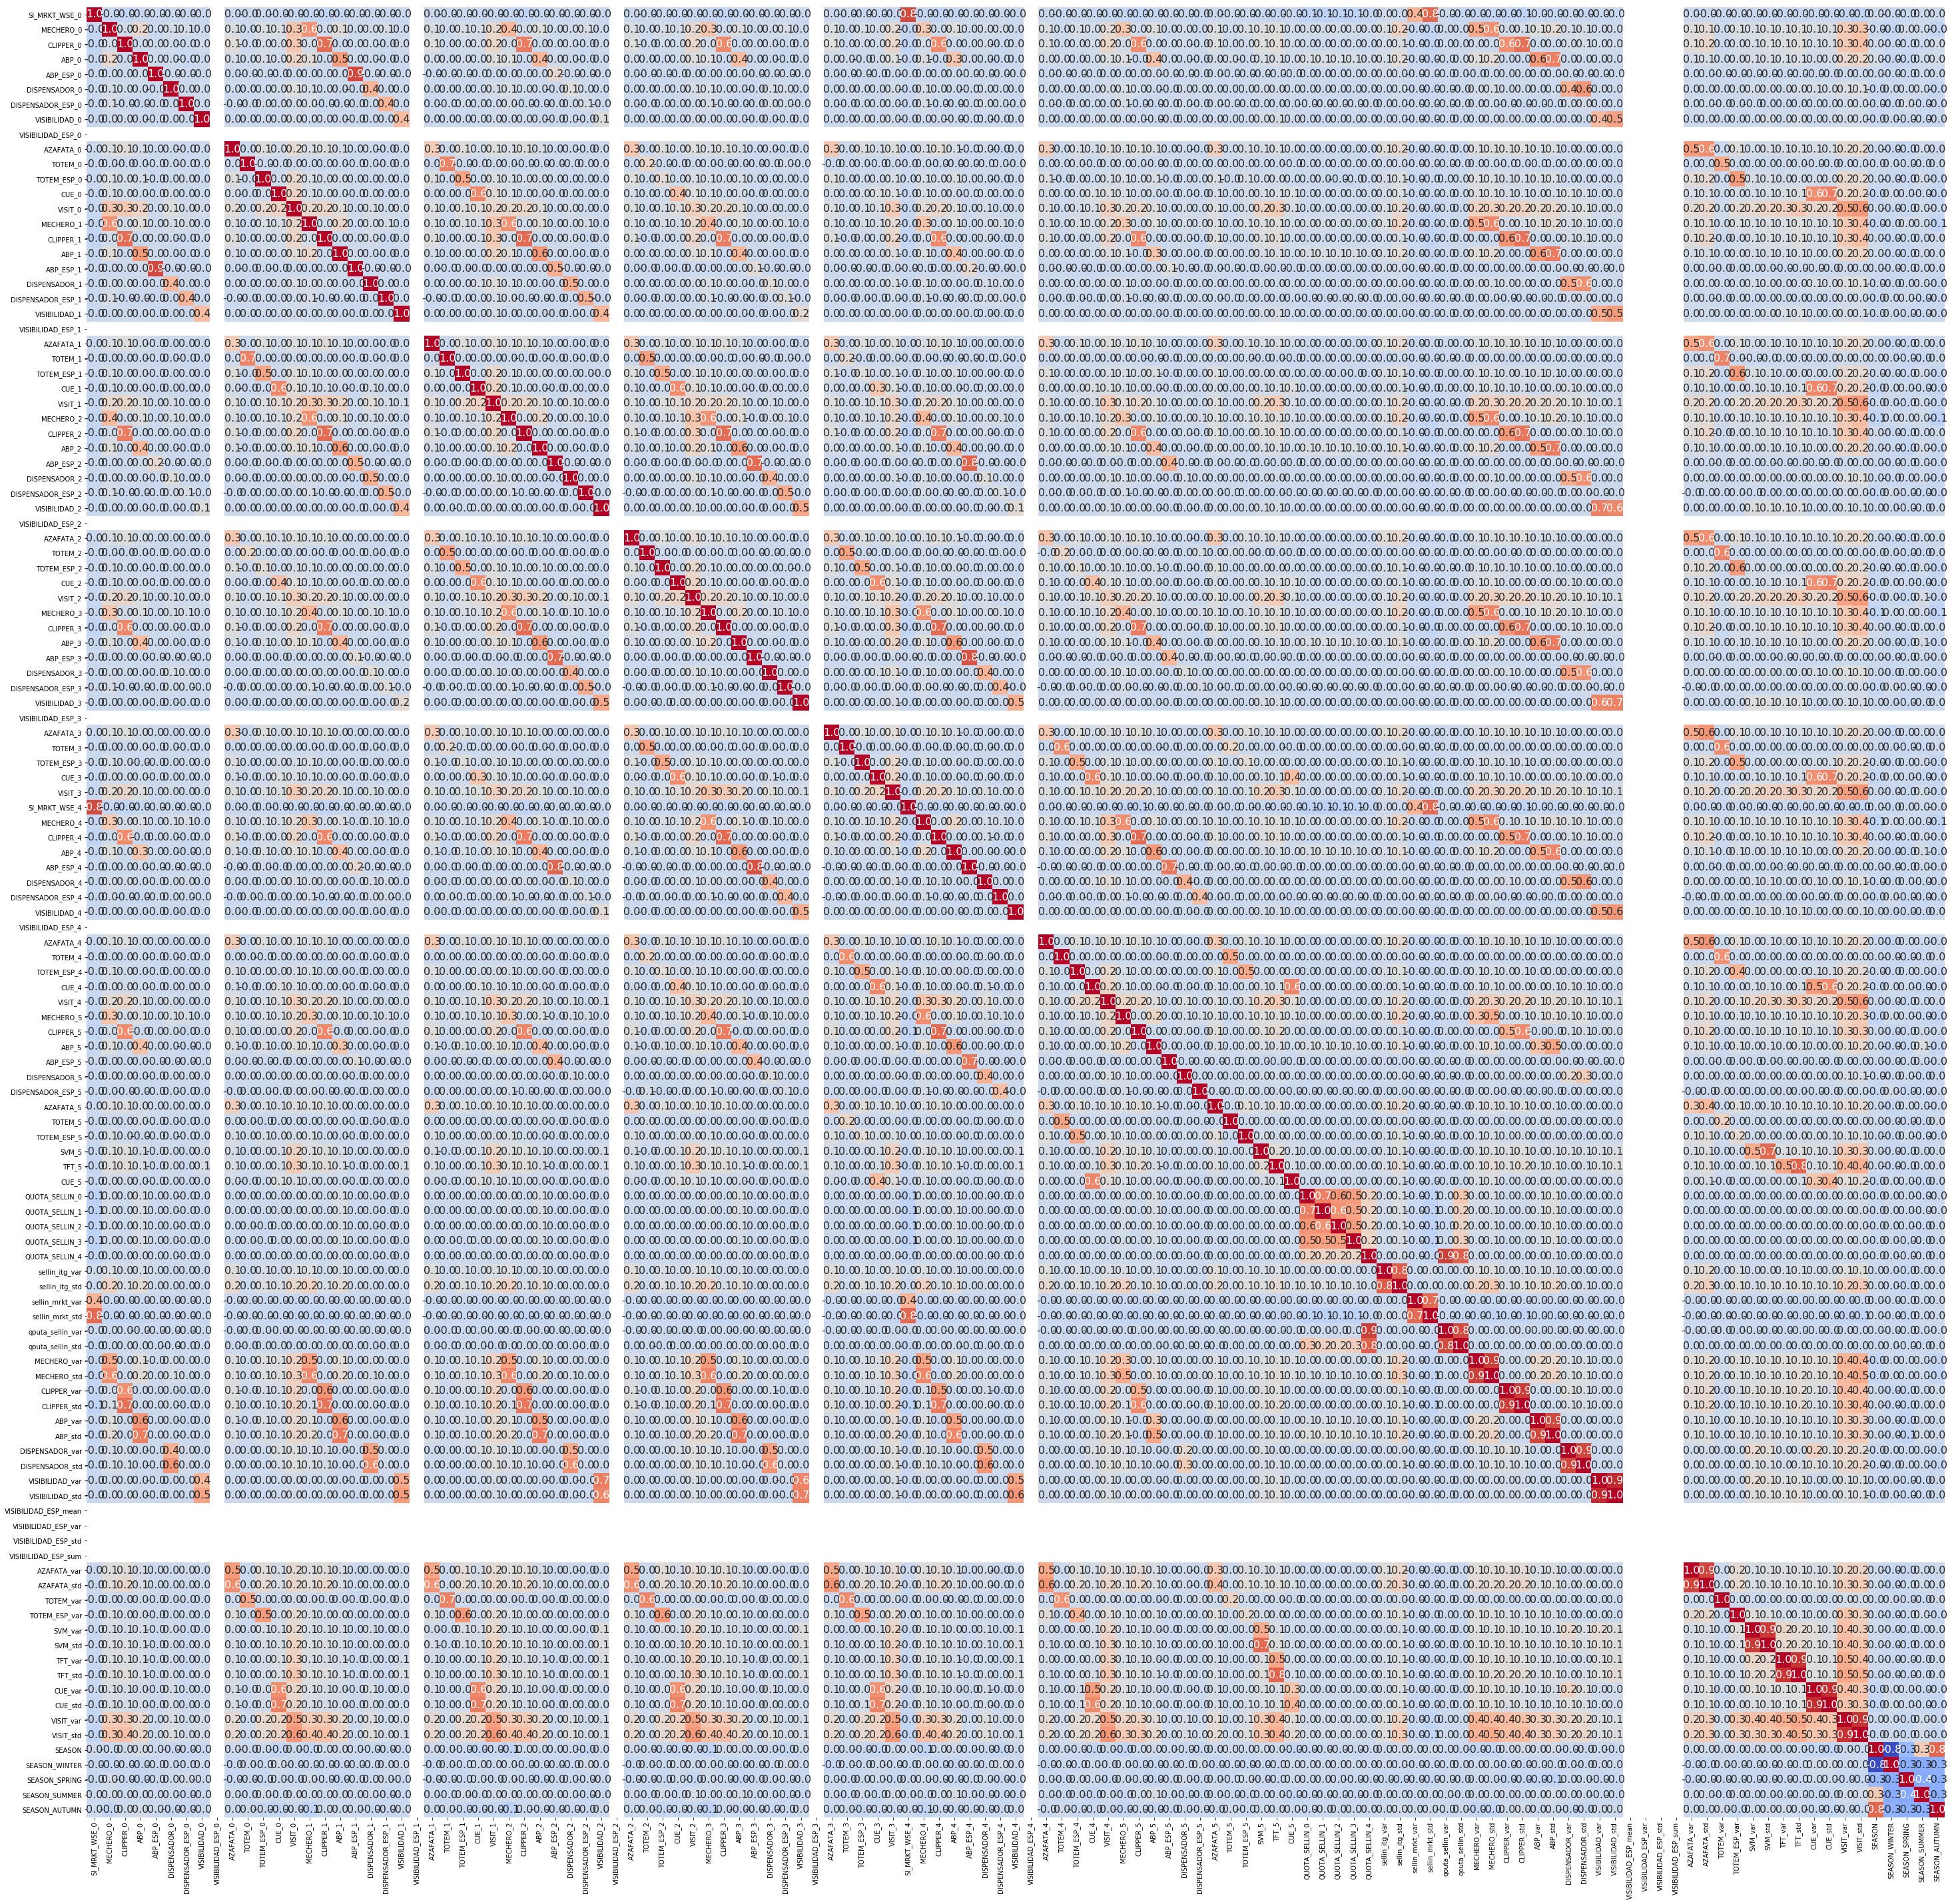

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(50,50))
sns.heatmap(correlations,
                cmap='coolwarm',
                annot=True,
                fmt=".1f",
                annot_kws={'size':16},
                cbar=False)

In [55]:
    threshold = 0.95
    ignored_fields = []
    for c in correlations.iterrows():
        sort = c[1].sort_values(ascending=False)
        if sort[1] > threshold or sort[1] < -threshold:
            correlations = correlations.drop(c[0], axis = 0)
            correlations = correlations.drop(c[0], axis = 1)
            ignored_fields.append(c[0])

In [56]:
 X = X.drop(ignored_fields, axis=1)
    
columns = list(X.columns.values)
    
# Standard scaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

c:\users\esmijlmog\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\esmijlmog\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [59]:
from sklearn.feature_selection import RFECV

# Select top 20 features
estimator = ltb.LGBMRegressor()
#rfe = RFE(estimator=estimator, n_features_to_select=40, step=10, verbose=1)
rfe = RFECV(estimator=estimator, min_features_to_select=30, step=10, cv=4, n_jobs=1, verbose=1)
rfe.fit(X, y)
features = rfe.get_support(indices = True) 
    
np.array(columns)[features]

Fitting estimator with 121 features.
Fitting estimator with 111 features.
Fitting estimator with 101 features.
Fitting estimator with 91 features.
Fitting estimator with 81 features.
Fitting estimator with 71 features.
Fitting estimator with 61 features.
Fitting estimator with 51 features.
Fitting estimator with 41 features.
Fitting estimator with 31 features.
Fitting estimator with 121 features.
Fitting estimator with 111 features.
Fitting estimator with 101 features.
Fitting estimator with 91 features.
Fitting estimator with 81 features.
Fitting estimator with 71 features.
Fitting estimator with 61 features.
Fitting estimator with 51 features.
Fitting estimator with 41 features.
Fitting estimator with 31 features.
Fitting estimator with 121 features.
Fitting estimator with 111 features.
Fitting estimator with 101 features.
Fitting estimator with 91 features.
Fitting estimator with 81 features.
Fitting estimator with 71 features.
Fitting estimator with 61 features.
Fitting estimator w

array(['SI_MRKT_WSE_0', 'MECHERO_0', 'CLIPPER_0', 'ABP_0',
       'DISPENSADOR_ESP_0', 'VISIT_0', 'CLIPPER_1', 'ABP_1', 'VISIT_1',
       'MECHERO_2', 'CLIPPER_2', 'ABP_2', 'DISPENSADOR_ESP_2', 'VISIT_2',
       'MECHERO_3', 'CLIPPER_3', 'ABP_3', 'TOTEM_ESP_3', 'VISIT_3',
       'SI_MRKT_WSE_4', 'MECHERO_4', 'CLIPPER_4', 'DISPENSADOR_ESP_4',
       'VISIT_4', 'MECHERO_5', 'CLIPPER_5', 'ABP_5', 'DISPENSADOR_ESP_5',
       'AZAFATA_5', 'TOTEM_ESP_5', 'SVM_5', 'TFT_5', 'CUE_5',
       'QUOTA_SELLIN_0', 'QUOTA_SELLIN_1', 'QUOTA_SELLIN_2',
       'QUOTA_SELLIN_3', 'QUOTA_SELLIN_4', 'sellin_itg_var',
       'sellin_itg_std', 'sellin_mrkt_var', 'sellin_mrkt_std',
       'qouta_sellin_var', 'qouta_sellin_std', 'MECHERO_var',
       'MECHERO_std', 'CLIPPER_var', 'ABP_var', 'ABP_std',
       'DISPENSADOR_var', 'AZAFATA_var', 'TOTEM_var', 'TOTEM_ESP_var',
       'SVM_var', 'TFT_var', 'CUE_var', 'VISIT_var', 'VISIT_std',
       'SEASON', 'SEASON_SPRING', 'SEASON_SUMMER'], dtype='<U20')

In [63]:
best_features = list(np.array(columns)[features])
    
X = data[['CUSTOMER_ID', 'BRANDFAMILY_ID', 'QUOTA_SELLOUT_5'] + best_features + date_cols]
    
np.save(OUTPUT_FEATS, list(X.columns.values))

In [64]:
X.to_hdf(OUTPUT, key='prepared_train', index=False, mode='w')

In [65]:
X.head()

,CUSTOMER_ID,BRANDFAMILY_ID,QUOTA_SELLOUT_5,SI_MRKT_WSE_0,MECHERO_0,CLIPPER_0,ABP_0,DISPENSADOR_ESP_0,VISIT_0,CLIPPER_1,ABP_1,VISIT_1,MECHERO_2,CLIPPER_2,ABP_2,DISPENSADOR_ESP_2,VISIT_2,MECHERO_3,CLIPPER_3,ABP_3,TOTEM_ESP_3,VISIT_3,SI_MRKT_WSE_4,MECHERO_4,CLIPPER_4,DISPENSADOR_ESP_4,VISIT_4,MECHERO_5,CLIPPER_5,ABP_5,DISPENSADOR_ESP_5,AZAFATA_5,TOTEM_ESP_5,SVM_5,TFT_5,CUE_5,QUOTA_SELLIN_0,QUOTA_SELLIN_1,QUOTA_SELLIN_2,QUOTA_SELLIN_3,QUOTA_SELLIN_4,sellin_itg_var,sellin_itg_std,sellin_mrkt_var,sellin_mrkt_std,qouta_sellin_var,qouta_sellin_std,MECHERO_var,MECHERO_std,CLIPPER_var,ABP_var,ABP_std,DISPENSADOR_var,AZAFATA_var,TOTEM_var,TOTEM_ESP_var,SVM_var,TFT_var,CUE_var,VISIT_var,VISIT_std,SEASON,SEASON_SPRING,SEASON_SUMMER,CAL_DATE_0,CAL_DATE_end_0,CAL_DATE_1,CAL_DATE_end_1,CAL_DATE_2,CAL_DATE_end_2,CAL_DATE_3,CAL_DATE_end_3,CAL_DATE_4,CAL_DATE_end_4,CAL_DATE_5,CAL_DATE_end_5
0,46010526,BF234104,16.214691,2674944.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2736840.0,5,0,0,0,8,0,0,0,0,0,0,0,0,0.193499,0.147163,0.134583,0.119950,0.132708,636755.2,797.969423,4.257915e+11,6.525270e+05,0.000811,0.028470,5.0,2.236068,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.447214,0,0,0,2017-12-21,2017-12-31,2018-01-01,2018-01-10,2018-01-11,2018-01-21,2018-01-22,2018-01-31,2018-02-01,2018-02-08,2018-02-09,2018-02-19
1,12000436,BF241151,8.198821,145428.0,0,3,0,0,3,6,0,0,0,8,0,0,0,0,3,0,0,0,436128.0,0,2,0,0,0,9,0,0,0,0,0,0,0,0.157466,0.208151,0.148703,0.156135,0.209801,83485.3,288.938229,3.382394e+10,1.839129e+05,0.000915,0.030247,0.0,0.000000,6.3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,1.341641,3,0,0,2018-10-01,2018-10-09,2018-10-10,2018-10-21,2018-10-22,2018-10-31,2018-11-01,2018-11-12,2018-11-13,2018-11-21,2018-11-22,2018-11-30
2,29002391,BF231048,30.093759,7663012.0,0,0,9,0,0,0,8,8,0,0,3,0,3,0,0,10,0,0,11640300.0,0,0,0,0,0,0,6,0,0,0,0,0,0,0.129923,0.149830,0.118716,0.093863,0.118485,8312002.3,2883.054335,1.675179e+13,4.092895e+06,0.000413,0.020322,0.0,0.000000,0.0,9.7,3.114482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.2,3.492850,2,0,1,2019-06-20,2019-06-30,2019-07-01,2019-07-09,2019-07-10,2019-07-18,2019-07-19,2019-07-31,2019-08-01,2019-08-11,2019-08-12,2019-08-21
3,15000011,BF231048,8.746846,3115019.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4764595.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.034863,0.020644,0.012749,0.014491,0.028187,41781.3,204.404746,2.468973e+12,1.571296e+06,0.000087,0.009319,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.447214,2,0,1,2018-05-23,2018-05-31,2018-06-01,2018-06-11,2018-06-12,2018-06-20,2018-06-21,2018-06-30,2018-07-01,2018-07-10,2018-07-11,2018-07-19
4,34000125,BF241066,1.609010,1498169.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1325910.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.060073,0.055668,0.069734,0.080373,0.042084,58133.2,241.108274,2.594320e+11,5.093446e+05,0.000209,0.014465,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.547723,3,0,0,2018-09-01,2018-09-10,2018-09-11,2018-09-19,2018-09-20,2018-09-30,2018-10-01,2018-10-09,2018-10-10,2018-10-21,2018-10-22,2018-10-31


In [ ]:
t2 = time.time()

print ("Time to execute script:",str(t2-t1))

In [69]:
import sys
print(sys.version) 

3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)]
